## Project looking at simulated hospital data

- Capital Investment Prioritization and Tracking System

- Goal: To develop a data-driven system that assists in evaluating, prioritizing, tracking, and reporting on capital investment proposals, ensuring alignment with strategic objectives and financial viability.

- This project addresses the need for a more efficient and transparent process for managing capital investment decisions within this simulated hospital data set. The system leverages data analytics, financial modeling, and forecasting techniques to provide a comprehensive framework for evaluating and prioritizing proposals based on their financial viability, strategic alignment, and risk level.

In [46]:
# Libraries needed
import numpy as np
import pandas as pd
from scipy.optimize import newton
from prophet import Prophet
import matplotlib.pyplot as plt

In [53]:
# Set the number of proposals
num_proposals = 50

# Create a DataFrame
proposals = pd.DataFrame({
    'Project Name': ['Project ' + str(i) for i in range(1, num_proposals + 1)],
    'Department': np.random.choice(['Cardiology', 'Oncology', 'Neurology', 'General Surgery'], num_proposals),
    'Project Description': ['Description for Project ' + str(i) for i in range(1, num_proposals + 1)],
    'Initial Investment': np.random.normal(loc=1000000, scale=250000, size=num_proposals),
    'Annual Operating Cost': np.random.normal(loc=50000, scale=10000, size=num_proposals),
    'Expected Lifespan': np.random.randint(5, 21, size=num_proposals),
    'Projected Annual Revenue': np.random.normal(loc=200000, scale=50000, size=num_proposals),
    'Strategic Alignment': np.random.randint(1, 6, size=num_proposals),
    'Risk Level': np.random.choice(['Low', 'Medium', 'High'], num_proposals)
})

# Display the simulated data
print(proposals.head())

  Project Name       Department        Project Description  \
0    Project 1         Oncology  Description for Project 1   
1    Project 2        Neurology  Description for Project 2   
2    Project 3       Cardiology  Description for Project 3   
3    Project 4  General Surgery  Description for Project 4   
4    Project 5        Neurology  Description for Project 5   

   Initial Investment  Annual Operating Cost  Expected Lifespan  \
0        8.892100e+05           15674.582022                 12   
1        1.101626e+06           53156.068869                 17   
2        8.114529e+05           55507.911304                  9   
3        6.268607e+05           61446.324414                 14   
4        9.296147e+05           27571.996396                 14   

   Projected Annual Revenue  Strategic Alignment Risk Level  
0             201868.706305                    3        Low  
1             231253.149374                    2       High  
2             277735.563044           

In [54]:
# Check for NAs
# Handling missing values (replace with mean)
proposals['Initial Investment'].fillna(proposals['Initial Investment'].mean(), inplace=True)

# Formatting (convert 'Risk Level' to categorical)
proposals['Risk Level'] = pd.Categorical(proposals['Risk Level'], categories=['Low', 'Medium', 'High'], ordered=True)

# Transformation (create dummy variables for 'Department')
proposals = pd.get_dummies(proposals, columns=['Department'], prefix=['Dept'])

<ipython-input-54-7a86c0edecb4>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  proposals['Initial Investment'].fillna(proposals['Initial Investment'].mean(), inplace=True)


In [55]:
# Uncheck to Save
# proposals.to_csv('capital_investment_proposals.csv', index=False)

# Load Simulated Data for reproducibility
proposals = pd.read_csv('capital_investment_proposals.csv')

In [56]:
# Functions
def calculate_npv(initial_investment, annual_cash_flows, discount_rate):
  """Calculates Net Present Value (NPV)."""
  npv = -initial_investment + sum(
      [cf / ((1 + discount_rate)**(i + 1)) for i, cf in enumerate(annual_cash_flows)]
  )
  return npv

def calculate_irr(initial_investment, annual_cash_flows):
  """Calculates Internal Rate of Return (IRR)."""
  def npv_function(rate):
    return calculate_npv(initial_investment, annual_cash_flows, rate)

  try:
    irr = newton(npv_function, 0.1) # Initial guess for IRR
  except RuntimeError:
    irr = np.nan  # Handle cases where IRR cannot be calculated
  return irr

def calculate_payback_period(initial_investment, annual_cash_flows):
  """Calculates Payback Period."""
  cumulative_cash_flow = 0
  payback_period = 0
  for i, cf in enumerate(annual_cash_flows):
    cumulative_cash_flow += cf
    if cumulative_cash_flow >= initial_investment:
      payback_period = i + 1
      break
  return payback_period

# Assuming a discount rate of 10%
discount_rate = 0.10

# Calculate NPV, IRR, and Payback Period for each project and add them as columns to the DataFrame
proposals['NPV'] = proposals.apply(lambda row: calculate_npv(row['Initial Investment'],
                                                            [row['Projected Annual Revenue'] - row['Annual Operating Cost']] * row['Expected Lifespan'],
                                                            discount_rate), axis=1)
proposals['IRR'] = proposals.apply(lambda row: calculate_irr(row['Initial Investment'],
                                                            [row['Projected Annual Revenue'] - row['Annual Operating Cost']] * row['Expected Lifespan']), axis=1)
proposals['Payback Period'] = proposals.apply(lambda row: calculate_payback_period(row['Initial Investment'],
                                                                                  [row['Projected Annual Revenue'] - row['Annual Operating Cost']] * row['Expected Lifespan']), axis=1)

In [57]:
# Initialize variables to store the best project and its metrics
best_project_npv = None
best_npv = -np.inf  # Initialize with negative infinity

best_project_irr = None
best_irr = -np.inf

best_project_payback = None
shortest_payback = np.inf  # Initialize with positive infinity

# Loop through all projects
for index, row in proposals.iterrows():
    project_name = row['Project Name']
    npv = row['NPV']
    irr = row['IRR']
    payback_period = row['Payback Period']

    # Check for the best project based on NPV
    if npv > best_npv:
        best_npv = npv
        best_project_npv = project_name

    # Check for the best project based on IRR
    if irr > best_irr:
        best_irr = irr
        best_project_irr = project_name

    # Check for the best project based on Payback Period
    if payback_period < shortest_payback:
        shortest_payback = payback_period
        best_project_payback = project_name

# Print the results
print(f"Best project based on NPV: {best_project_npv} (NPV: {best_npv:.2f})")
print(f"Best project based on IRR: {best_project_irr} (IRR: {best_irr:.2f})")
print(f"Best project based on Payback Period: {best_project_payback} (Payback Period: {shortest_payback:.2f})")

Best project based on NPV: Project 22 (NPV: 1175368.88)
Best project based on IRR: Project 42 (IRR: 0.30)
Best project based on Payback Period: Project 4 (Payback Period: 0.00)


## Interpreting Metrics

NPV:

- Project 22 has the highest Net Present Value (NPV) among all the projects, with an NPV of $1,175,368.88. This suggests that Project 22 is expected to generate the most significant positive cash flow over its lifetime, discounted to the present value.
- Financial Viability: A higher NPV indicates a more financially viable project, as it represents a greater return on investment.

IRR:

- Project 42 has the highest Internal Rate of Return (IRR) among all the projects, with an IRR of 0.30 (or 30%). This means that Project 42 is expected to generate a 30% return on investment per year.
- Rate of Return: A higher IRR is generally preferred, as it represents a higher rate of return on the investment.

Payback Period:

- Project 4 has the shortest Payback Period among all the projects, with a payback period of 0.00. This implies that Project 4 is expected to recover its initial investment immediately or within the first year.
- Investment Recovery: A shorter payback period is generally desirable, as it indicates a quicker recovery of the initial investment and reduced risk.


In [58]:
# Forcast Data using Prophet. Why? Becuase it uses the Generalized Additive Model (GAM)
# Prepare data for Prophet (requires 'ds' for dates and 'y' for values)
forecast_data = pd.DataFrame({'ds': pd.date_range(start='2024-01-01', periods=5, freq='Y'),
                                'y': proposals['Projected Annual Revenue'].head(5)}) # 5 years

# Create and fit the Prophet model
model = Prophet()
model.fit(forecast_data)

# Make future predictions
future = model.make_future_dataframe(periods=5, freq='Y')
forecast = model.predict(future)

# Access forecasted values
print(forecast[['ds', 'yhat']].tail()) # Display the last 5 years of forecasted revenue

<ipython-input-58-813a3ecb8fbb>:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  forecast_data = pd.DataFrame({'ds': pd.date_range(start='2024-01-01', periods=5, freq='Y'),
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp31ntuvb3/j_5kcck5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp31ntuvb3/ro4qys5h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36658', 'data', 'file=/tmp/tmp31ntuvb3/j_5kcck5.json', 'init=/tmp/tmp31ntuvb3/ro4qys5h.json', 'output', 'file=/tmp/tmp31ntuvb3/prophet_modelgx0czjsj/prophet_model-2025050

          ds           yhat
5 2029-12-31  168799.081106
6 2030-12-31  143004.486849
7 2031-12-31  115942.575554
8 2032-12-31  145931.646433
9 2033-12-31  121421.282433


## Table Interpretation

The Prophet forecast table provides the numerical data points that are visualized in the forecast plot. The plot enhances understanding by showing the overall trend, significant changes, and uncertainty in the projected revenue, supporting better interpretation and communication of the forecast results.

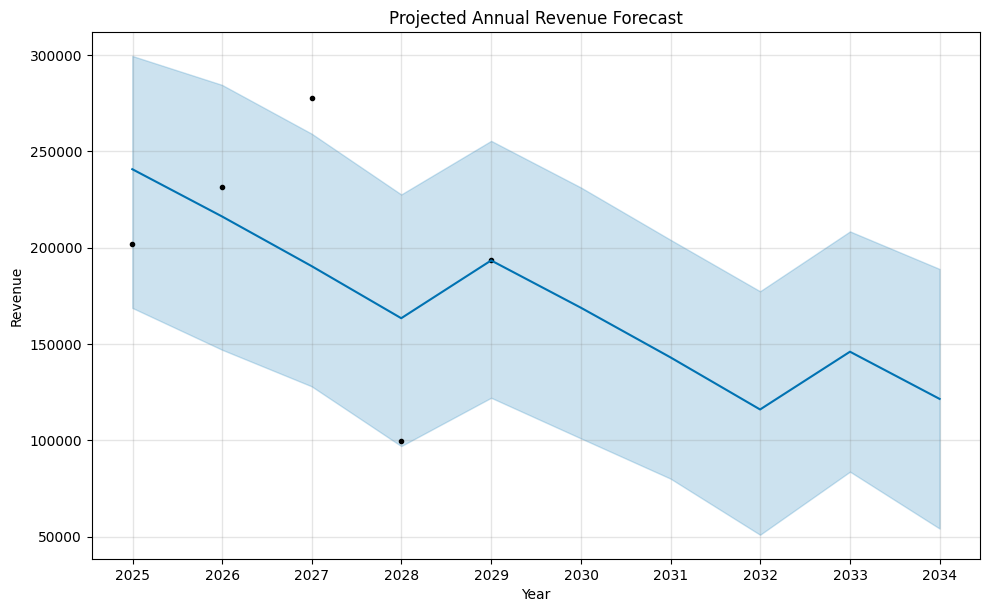

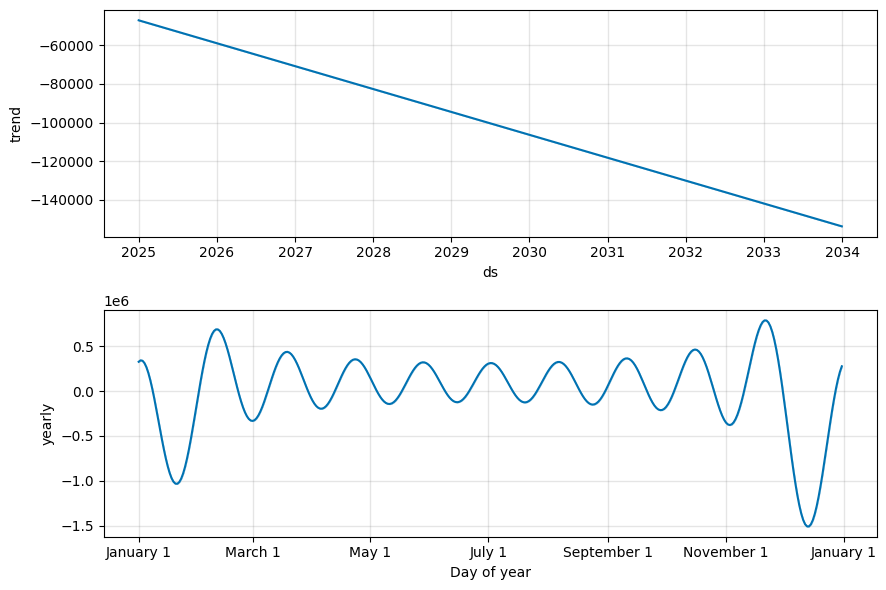

In [59]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title("Projected Annual Revenue Forecast")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.show()

# Plot the forecast components (trend, seasonality, etc.)
fig2 = model.plot_components(forecast)
plt.show()

## Interpretations to graphs above

- ds: Represents the date of the forecast (year-end dates from 2029 to 2033)
- yhat: Represents the forecasted value of the target variable, which in this case is "Projected Annual Revenue
- The forecasted values in this table directly correspond to the line representing the predicted revenue in the Prophet forecast plot (model.plot(forecast)). This line visually depicts the trend and changes in projected revenue over time

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp31ntuvb3/u0shnws5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp31ntuvb3/zv85b2g8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35736', 'data', 'file=/tmp/tmp31ntuvb3/u0shnws5.json', 'init=/tmp/tmp31ntuvb3/zv85b2g8.json', 'output', 'file=/tmp/tmp31ntuvb3/prophet_modelindebn66/prophet_model-20250505165247.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

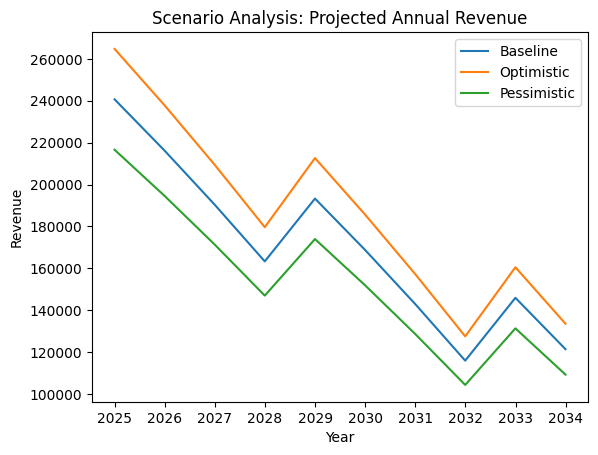

In [60]:
# Optimistic scenario: Increase projected revenue by 10%
forecast_data_optimistic = forecast_data.copy()
forecast_data_optimistic['y'] = forecast_data_optimistic['y'] * 1.1

model_optimistic = Prophet()
model_optimistic.fit(forecast_data_optimistic)
forecast_optimistic = model_optimistic.predict(future)

# Pessimistic scenario: Decrease projected revenue by 10%
forecast_data_pessimistic = forecast_data.copy()
forecast_data_pessimistic['y'] = forecast_data_pessimistic['y'] * 0.9

model_pessimistic = Prophet()
model_pessimistic.fit(forecast_data_pessimistic)
forecast_pessimistic = model_pessimistic.predict(future)

# Plot the scenarios
plt.plot(forecast['ds'], forecast['yhat'], label='Baseline')
plt.plot(forecast_optimistic['ds'], forecast_optimistic['yhat'], label='Optimistic')
plt.plot(forecast_pessimistic['ds'], forecast_pessimistic['yhat'], label='Pessimistic')
plt.title("Scenario Analysis: Projected Annual Revenue")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.legend()
plt.show()